In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize, LogNorm, ListedColormap
import hydroeval as he
import h5py
import datetime as dt

sys.path.append('../')
sys.path.append('../pywrdrb/')

from pywrdrb.post.get_results import get_pywr_results, get_base_results

from pywrdrb.pywr_drb_node_data import upstream_nodes_dict

# Custom modules

from pywrdrb.utils.constants import cms_to_mgd, cm_to_mg, cfs_to_mgd
from pywrdrb.utils.lists import reservoir_list, majorflow_list, reservoir_link_pairs, reservoir_list_nyc
from pywrdrb.utils.directories import input_dir, fig_dir, output_dir, model_data_dir
from pywrdrb.utils.hdf5 import get_hdf5_realization_numbers

from pywrdrb.plotting.styles import base_model_colors, model_hatch_styles, paired_model_colors, scatter_model_markers
import pywrdrb.plotting



In [2]:
## Load observed data

lower_elevations= pd.read_csv(f'{input_dir}historic_reservoir_ops/lower_basin_reservoir_elevation.csv', 
                            index_col=0, parse_dates=True)

storage_curves = {}
for res in ['blueMarsh', 'beltzvilleCombined', 'fewalter']:
    storage_curves[res]= pd.read_csv(f'{input_dir}historic_reservoir_ops/{res}_elevation_storage_curve.csv', sep=',')

### get reservoir storage capacities
istarf = pd.read_csv(f'{model_data_dir}drb_model_istarf_conus.csv')
def get_reservoir_capacity(reservoir):
    return float(istarf['Adjusted_CAP_MG'].loc[istarf['reservoir'] == reservoir].iloc[0])
capacities = {r: get_reservoir_capacity(r) for r in reservoir_list_nyc}
capacities['combined'] = sum([capacities[r] for r in reservoir_list_nyc])

nyc_hist_storage = pd.read_csv(f'{input_dir}/historic_NYC/NYC_storage_daily_2000-2021.csv', sep=',', index_col=0, parse_dates=True)
nyc_hist_storage.index = pd.to_datetime(nyc_hist_storage.index)


In [3]:
## Load data    
start_date = '1950-01-01'
end_date = '2022-12-31'
n_realizations=30

# Load Pywr-DRB simulation models
if end_date > '2016-12-31':
    pywr_models= ['obs_pub_nwmv21_NYCScaled','obs_pub_nhmv10_NYCScaled_modified_starfit',
                'obs_pub_nwmv21_NYCScaled_ensemble','obs_pub_nhmv10_NYCScaled_ensemble']

    base_models = ['obs', 'obs_pub_nhmv10_NYCScaled','obs_pub_nwmv21_NYCScaled']

else:
    pywr_models= ['nhmv10', 'nwmv21',
                  'obs_pub_nhmv10_NYCScaled_modified_starfit', 
                  'obs_pub_nwmv21_NYCScaled',
                'obs_pub_nwmv21_NYCScaled_ensemble','obs_pub_nhmv10_NYCScaled_ensemble']

    base_models = ['obs', 'obs_pub_nhmv10_NYCScaled','obs_pub_nwmv21_NYCScaled', 'nhmv10', 'nwmv21']

# Test only modified starfit    
pywr_models= ['obs_pub_nhmv10_NYCScaled', 'obs_pub_nhmv10']
# 'obs_pub_nhmv10_NYCScaled_default_starfit',  


reservoir_downstream_gages = {}
major_flows = {}
storages={}
inflows={}
datetime_index = None

for model in pywr_models:
    print(model)
    if 'ensemble' in model:
        reservoir_downstream_gages[f'pywr_{model}'] = {}
        major_flows[f'pywr_{model}'] = {}
        storages[f'pywr_{model}']={}
        n_realizations = 30 if model == 'obs_pub_nhmv10_NYCScaled_ensemble' else 20

        for i in range(n_realizations):
            reservoir_downstream_gages[f'pywr_{model}'][f'realization_{i}'], datetime_index = get_pywr_results(output_dir, model, 'reservoir_downstream_gage', datetime_index=datetime_index, scenario=i)
            reservoir_downstream_gages[f'pywr_{model}'][f'realization_{i}']= reservoir_downstream_gages[f'pywr_{model}'][f'realization_{i}'].loc[start_date:end_date,:]
            
            major_flows[f'pywr_{model}'][f'realization_{i}'], datetime_index = get_pywr_results(output_dir, model, 'major_flow', datetime_index=datetime_index, scenario=i)
            major_flows[f'pywr_{model}'][f'realization_{i}']= major_flows[f'pywr_{model}'][f'realization_{i}'].loc[start_date:end_date,:]
            
            storages[f'pywr_{model}'][f'realization_{i}'], datetime_index = get_pywr_results(output_dir, model, 'res_storage', datetime_index=datetime_index, scenario=i)
    else:
        reservoir_downstream_gages[f'pywr_{model}'], datetime_index = get_pywr_results(output_dir, model, 'reservoir_downstream_gage', datetime_index=datetime_index)
        reservoir_downstream_gages[f'pywr_{model}'] = reservoir_downstream_gages[f'pywr_{model}'].loc[start_date:end_date,:]
        
        major_flows[f'pywr_{model}'], datetime_index = get_pywr_results(output_dir, model, 'major_flow', datetime_index=datetime_index)
        major_flows[f'pywr_{model}'] = major_flows[f'pywr_{model}'].loc[start_date:end_date,:]
        inflows[f'pywr_{model}'], datetime_index = get_pywr_results(output_dir, model, 'inflow', datetime_index=datetime_index)

        storages[f'pywr_{model}'], datetime_index = get_pywr_results(output_dir, model, 'res_storage', datetime_index=datetime_index)
pywr_models = [f'pywr_{m}' for m in pywr_models]


# Load base (non-pywr) models
datetime_index = list(reservoir_downstream_gages.values())[0].index
for model in base_models:
    print(model)
    reservoir_downstream_gages[model] = get_base_results(input_dir, model, datetime_index, 'reservoir_downstream_gage').loc[start_date:end_date,:]
    major_flows[model] = get_base_results(input_dir, model, datetime_index, 'major_flow').loc[start_date:end_date,:]

obs_pub_nhmv10_NYCScaled
obs_pub_nhmv10
obs
obs_pub_nhmv10_NYCScaled
obs_pub_nwmv21_NYCScaled


(1000, 10000)

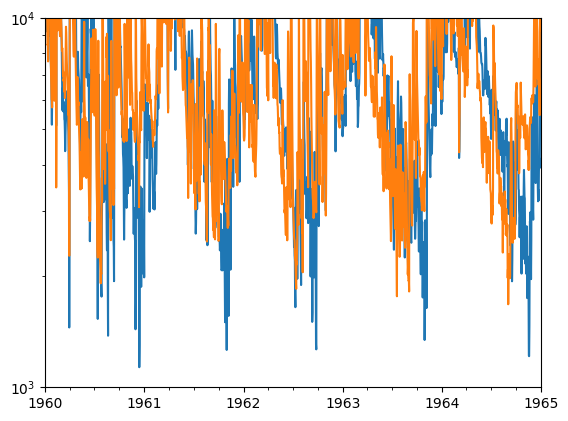

In [4]:
fig,ax=plt.subplots()
major_flows['pywr_obs_pub_nhmv10'].loc['1960-01-01':'1965-01-01', 'delDRCanal'].plot(ax=ax)
major_flows['pywr_obs_pub_nhmv10_NYCScaled'].loc['1960-01-01':'1965-01-01', 'delTrenton'].plot(ax=ax)
plt.yscale('log')
plt.ylim([1000, 10000])

In [5]:
sim_levels, _ = get_pywr_results(output_dir, 'obs_pub_nhmv10_NYCScaled', results_set='res_level', 
                 datetime_index=major_flows['obs_pub_nhmv10_NYCScaled'].index)

<Axes: >

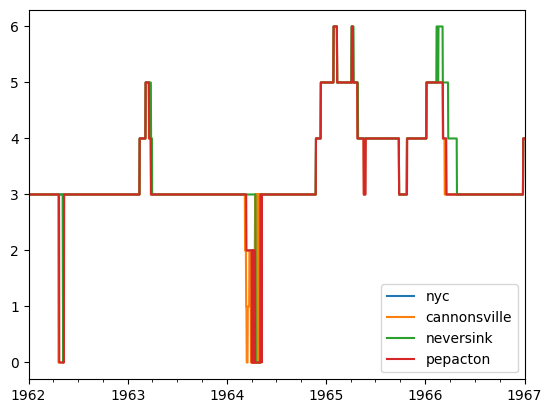

In [20]:
sim_levels.loc['1962-01-01':'1967-01-01'].plot()

In [32]:
np.unique(sim_levels['nyc'])

array([0, 1, 2, 3, 4, 5, 6])

In [6]:
## Plot all reservoir storages in lower basins
lower_elevations= pd.read_csv(f'{input_dir}historic_reservoir_ops/lower_basin_reservoir_elevation.csv', 
                            index_col=0, parse_dates=True)

def plot_reservoir_dynamics(reservoir, storage_results, release_results,
                            major_flows,
                            t_start, t_end,
                            smooth_releases=True, 
                            window_size=5,
                            percent_storage=True, log_releases=True,
                            plot_ensemble=True,
                            plot_observed=True):
    
    # assert(list(storage_results.keys()) == list(release_results.keys())), 'Input storage and release dict keys dont match.'

    plot_models = list(storage_results.keys())
    storage_capacity = get_reservoir_capacity(reservoir)

    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,6), sharex=True)
    ax1.set_title(reservoir)
    ax1.set_position([0.1, 0.55, 0.9, 0.4])
    ax2.set_position([0.1, 0.1, 0.9, 0.4])
    
    for model in plot_models:
        
        if model == 'pywr_obs_pub_nhmv10_NYCScaled_default_starfit':
            lab = 'Default STARFIT Parameterization (NHM inflows)' 
            c = 'cornflowerblue'
        elif model == 'pywr_obs_pub_nhmv10_NYCScaled_linear_below_NOR_starfit':
            lab = 'Default STARFIT with linear releases below NOR' 
            c = 'darkorchid'
        elif model == 'pywr_obs_pub_nhmv10_NYCScaled_modified_starfit':
            lab = 'Modified STARFIT Parameterization'  
            c = 'darkorange'  
        else:
            c = 'grey'
            lab = model
        
        # Plot single traces
        if 'ensemble' not in model:
            sd = storages[model].loc[t_start:t_end, reservoir]
            if percent_storage:
                sd=sd/storage_capacity*100
            # Plot storages
            ax2.plot(sd, color=c, alpha=0.9, zorder=2, label=lab)
            
            # Plot releases
            rd = release_results[model].loc[t_start:t_end, reservoir]
            if smooth_releases:
                rd_rolling=rd.rolling(window=window_size).mean().values
                rd_rolling[0:window_size]=rd.values[0:window_size]
                rd_rolling[-window_size:]=rd.values[-window_size:]
                rd= rd_rolling
            ax1.plot(sd.index, rd, color= c, alpha=0.9, zorder=2, label=lab)
            
        elif plot_ensemble and ('ensemble' in model):
            n_realizations=len(storage_results[model])
            lab = 'NHM-based QPPQ Ensemble' if 'nhmv10' in model else 'NWM-based QPPQ Ensemble'  
            for i in range(n_realizations):
                
                # Get storage
                sd = storages[model][f'realization_{i}'].loc[t_start:t_end, reservoir]
                if percent_storage:
                    sd= sd/storage_capacity*100
                    
                # get release 
                rd = release_results[model][f'realization_{i}'].loc[t_start:t_end, reservoir]
                if smooth_releases:
                    rd_rolling=rd.rolling(window=window_size).mean().values
                    rd_rolling[0:window_size]=rd.values[0:window_size]
                    rd_rolling[-window_size:]=rd.values[-window_size:]
                    rd= rd_rolling
                
                if i == 0:
                    # Plot with label
                    ax2.plot(sd, color='grey', alpha=0.7, zorder=1, label=lab)
                    ax1.plot(sd.index, rd, color= c, alpha=0.1, zorder=2, label=lab)
                else:
                    ax2.plot(sd, color='grey', alpha=0.1, zorder=1)
                    ax1.plot(sd.index, rd, color= c, alpha=0.1, zorder=2)
    
    # Add observed data
    if plot_observed:
        if reservoir in lower_elevations.columns:
            curve= storage_curves[reservoir]
            lb_elev= lower_elevations.loc[t_start:t_end, reservoir]
            lb_stor = np.interp(lb_elev.dropna().values, curve['Elevation (ft)'],
                                curve['BG'])
            lb_stor = lb_stor*1000
            if percent_storage:
                lb_stor=lb_stor / storage_capacity*100
            ax2.plot(lb_elev.dropna().index, lb_stor, 
                    color='black', alpha=1, zorder=3, label='Observed', ls='dashed')
        
        # Observed Releases
        obs_release= major_flows['obs'].loc[t_start:t_end, reservoir_link_pairs[reservoir]]
        if smooth_releases:
            rd_rolling=obs_release.rolling(window=window_size).mean().values
            rd_rolling[0:window_size]=obs_release.values[0:window_size]
            rd_rolling[-window_size:]=obs_release.values[-window_size:]
            rd= rd_rolling
        else:
            rd=obs_release
        ax1.plot(sd.index, rd, color='black', zorder=3, label='Observed', ls='dashed')

    ax2.legend(fontsize=12, bbox_to_anchor=[0.5,-0.15], loc='upper center')
    if log_releases:
        ax1.set_yscale('log')
        
  
    # ax1.set_ylim([10, 25])
    
    ax2.set_ylabel('Storage (%)', fontsize=16)
    ax1.set_ylabel('Release (MGD)', fontsize=16)
    # ax.grid('minor')
    fig.align_labels()
    # plt.tight_layout()
    plt.show()
